# Rock Climbing Biomechanical Analysis

In this notebook, I will analyze a pair of Youtube video segments of someone climbing indoor rock walls vertically with respect to the wall. The first video is climbing a system board, effectively in a straight path, which is compared to the second video where the climber transitions to a second segment of the wall inclined at a roughly perpendicular angle to the first (a volume).

The goal of the analysis is to derive estimates of peak loads experienced by a climber's hands and feet while undergoing each of these 2 motions. I will also plot and display the observed Cartesian and angular displacements of each joint over time. Finally, I will examine for cyclicality of the motions to determine if the peak loads can then themselves be cyclically approximated. 

Credits to Dave Lin for his rock climbing videos on a system board (https://www.youtube.com/watch?v=cl3O8kg-Mso) and a volume (https://www.youtube.com/watch?v=5vDUe0JU3iA) that I used for this analysis.

In [1]:
#!pip install opencv-python
#!pip install ffmpeg
import cv2 # Make sure ffmpeg is also installed to handle videos properly!
import time
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Setting up parameters for the COCO model

In [2]:
protoFile = "pose_deploy_linevec.prototxt"
weightsFile = "pose_iter_440000.caffemodel"
nPoints = 18
POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

### Preparing Video Frames

The videos will now be loaded through OpenCV and analyzed frame by frame, starting with the baseline video, then with the video of the volume.

Every fifth frame will be read (using modulo operator), and the corresponding frames saved as .jpg in their respective folders (I have already saved a set, if you wish to modify the function, delete the contents of the folders first!)

In [3]:
cap1 = cv2.VideoCapture('baseline.mp4')
length1 = int(cap1.get(cv2.CAP_PROP_FRAME_COUNT))
print("Loaded in baseline video, frames: ", length1)
success,image = cap1.read()
count = 0
while success:
  if count % 5 == 0:
    cv2.imwrite("Baseline_frames/frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = cap1.read()
  if success == False:
    print('Failed to read frame ', count)
  count += 1
cap1.set(cv2.CAP_PROP_POS_AVI_RATIO,1)
time1 = cap1.get(cv2.CAP_PROP_POS_MSEC)
cap1.release()
num_baseline_frames = count // 5 # Number of analyzed frames
print("Done creating Baseline frames!")

Loaded in baseline video, frames:  540
Failed to read frame  539
Done creating Baseline frames!


In [4]:
cap2 = cv2.VideoCapture('volume.mp4')
length2 = int(cap2.get(cv2.CAP_PROP_FRAME_COUNT))
print("Loaded in volume video, frames: ", length2)
success,image = cap2.read()
count = 0
while success:
  if count % 5 == 0:
    cv2.imwrite("Volume_frames/frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = cap2.read()
  if success == False:
    print('Failed to read frame ', count)
  count += 1
cap2.set(cv2.CAP_PROP_POS_AVI_RATIO,1)
time2 = cap2.get(cv2.CAP_PROP_POS_MSEC)
cap2.release()
num_volume_frames = count // 5 # Number of analyzed frames
print("Done creating Volume frames!")

Loaded in volume video, frames:  248
Failed to read frame  247
Done creating Volume frames!


### Analyze Videos

I will now prepare to analyze the videos using the OpenPose model, in order to obtain positional data for each joint with respect to time. First, we derive the time associated with each frame using the total number of frames per video and total video length (in milliseconds): 

In [5]:
print(time1, time2)
time_per_frame_1 = time1 / length1
time_per_frame_2 = time2 / length2
print(time_per_frame_1, time_per_frame_2)

18018.0 8274.933333333334
33.36666666666667 33.36666666666667


#### Dataframe Setup

In [6]:
baseline_poses = pd.DataFrame()
volume_poses = pd.DataFrame()
frame_ids_1 = [*range(0, length1, 5)]
frame_ids_2 = [*range(0, length2, 5)]
baseline_poses["frame_id"] = frame_ids_1
volume_poses["frame_id"] = frame_ids_2
pd.options.display.float_format = '{:,.2f}'.format # Sets floats to 2 decimal places
baseline_poses["time_seconds"] = (baseline_poses["frame_id"] * time_per_frame_1)/1000
volume_poses["time_seconds"] = (volume_poses["frame_id"] * time_per_frame_2)/1000
print('Baseline poses: {}\n Volume poses: {}'.format(baseline_poses.shape, volume_poses.shape))

Baseline poses: (108, 2)
 Volume poses: (50, 2)


In [7]:
baseline_poses.head()

,frame_id,time_seconds
0,0,0.00
1,5,0.17
2,10,0.33
3,15,0.50
4,20,0.67


In [8]:
volume_poses.head()

,frame_id,time_seconds
0,0,0.00
1,5,0.17
2,10,0.33
3,15,0.50
4,20,0.67


In [9]:
baseline_poses.describe()

,frame_id,time_seconds
count,108.00,108.00
mean,267.50,8.93
std,156.60,5.23
min,0.00,0.00
25%,133.75,4.46
50%,267.50,8.93
75%,401.25,13.39
max,535.00,17.85


In [10]:
volume_poses.describe()

,frame_id,time_seconds
count,50.00,50.00
mean,122.50,4.09
std,72.89,2.43
min,0.00,0.00
25%,61.25,2.04
50%,122.50,4.09
75%,183.75,6.13
max,245.00,8.17


Now, we iterate over each frame of the baseline and volume videos that we saved earlier, and collect joint data from each one to store in a Panda dataframe.

In [11]:
def get_poses(dataframe, pathname, displayframe):
    num_frames = len(dataframe["frame_id"])
    joint0, joint1, joint2, joint3, joint4, joint5 = [],[],[],[],[],[]
    joint6, joint7, joint8, joint9, joint10, joint11 = [],[],[],[],[],[]
    joint12, joint13, joint14, joint15, joint16, joint17 = [],[],[],[],[],[]
    # Retrieved from https://github.com/spmallick/learnopencv/blob/master/OpenPose/OpenPose_Notebook.ipynb
    net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)
    inWidth = 368
    inHeight = 368
    for n in dataframe["frame_id"]:
        frame = cv2.imread("%s/frame%d.jpg" % (pathname, n))
        frameCopy = np.copy(frame)
        frameWidth = frame.shape[1]
        frameHeight = frame.shape[0]
        threshold = 0.1
        inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)
        net.setInput(inpBlob)
        output = net.forward()
        H = output.shape[2]
        W = output.shape[3]
        # Empty list to store the detected keypoints
        points = []

        for i in range(nPoints):
            # confidence map of corresponding body's part.
            probMap = output[0, i, :, :]

            # Find global maxima of the probMap.
            minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

            # Scale the point to fit on the original image
            x = (frameWidth * point[0]) / W
            y = (frameHeight * point[1]) / H

            if prob > threshold : 
                cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
                cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
                cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

                # Add the point to the list if the probability is greater than the threshold
                points.append((int(x), int(y)))
            else :
                points.append(None)
        if n == displayframe:
            plt.figure(figsize=[10,10])
            plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
            plt.figure(figsize=[10,10])
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        joint0.append(points[0])
        joint1.append(points[1])
        joint2.append(points[2])
        joint3.append(points[3])
        joint4.append(points[4])
        joint5.append(points[5])
        joint6.append(points[6])
        joint7.append(points[7])
        joint8.append(points[8])
        joint9.append(points[9])
        joint10.append(points[10])
        joint11.append(points[11])
        joint12.append(points[12])
        joint13.append(points[13])
        joint14.append(points[14])
        joint15.append(points[15])
        joint16.append(points[16])
        joint17.append(points[17])
    dataframe["joint0"] = joint0
    dataframe["joint1"] = joint1
    dataframe["joint2"] = joint2
    dataframe["joint3"] = joint3
    dataframe["joint4"] = joint4
    dataframe["joint5"] = joint5
    dataframe["joint6"] = joint6
    dataframe["joint7"] = joint7
    dataframe["joint8"] = joint8
    dataframe["joint9"] = joint9
    dataframe["joint10"] = joint10
    dataframe["joint11"] = joint11
    dataframe["joint12"] = joint12
    dataframe["joint13"] = joint13
    dataframe["joint14"] = joint14
    dataframe["joint15"] = joint15
    dataframe["joint16"] = joint16
    dataframe["joint17"] = joint17
    return dataframe

,frame_id,time_seconds,joint0,joint1,joint2,joint3,joint4,joint5,joint6,joint7,joint8,joint9,joint10,joint11,joint12,joint13,joint14,joint15,joint16,joint17
0,0,0.00,None,"(626, 657)","(626, 633)",None,None,"(626, 657)","(709, 727)","(709, 751)","(709, 751)",None,None,"(709, 751)","(626, 821)",None,None,None,None,None
1,5,0.17,None,"(626, 633)","(626, 633)",None,None,"(626, 633)","(667, 704)",None,"(667, 727)","(542, 774)",None,"(667, 727)","(542, 774)","(584, 868)",None,None,None,None
2,10,0.33,None,None,None,None,None,"(626, 633)",None,None,"(626, 704)",None,None,"(667, 727)","(542, 704)","(500, 798)",None,None,None,None
3,15,0.50,None,None,None,None,"(834, 610)","(626, 633)",None,"(834, 610)",None,None,None,None,None,None,None,None,None,None
4,20,0.67,None,None,None,None,"(834, 610)",None,None,"(834, 610)",None,None,None,None,None,None,None,None,None,None
5,25,0.83,None,None,"(584, 610)",None,None,"(584, 610)",None,None,None,None,None,None,None,None,None,None,None,None
6,30,1.00,"(876, 563)","(834, 610)","(834, 586)","(834, 516)","(834, 446)","(876, 610)","(834, 516)","(834, 446)","(709, 704)",None,None,"(751, 704)",None,None,None,"(918, 540)",None,"(918, 563)"
7,35,1.17,"(751, 563)","(667, 610)","(626, 610)","(542, 680)",None,"(751, 633)",None,"(834, 516)",None,None,None,None,None,None,"(751, 540)","(751, 540)","(709, 540)",None
8,40,1.33,"(876, 493)","(876, 540)","(834, 540)",None,None,"(918, 563)","(834, 516)","(793, 469)",None,None,None,None,None,None,"(876, 469)","(918, 493)",None,"(918, 493)"
9,45,1.50,"(876, 469)","(834, 586)","(709, 586)",None,None,"(960, 586)",None,None,None,None,None,None,None,None,"(876, 446)","(918, 469)","(793, 469)","(960, 493)"


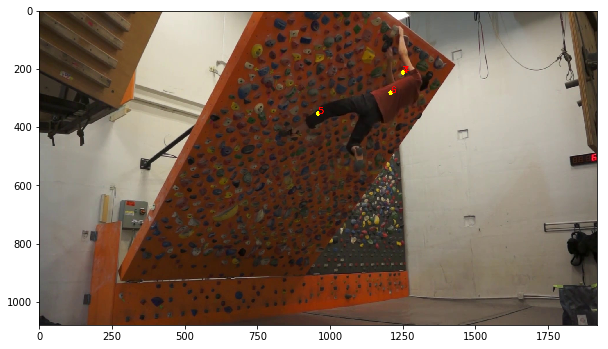

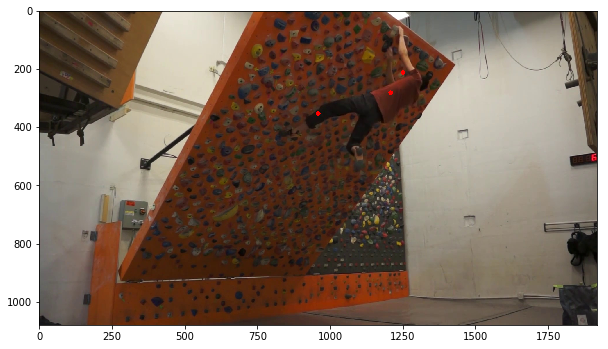

In [72]:
get_poses(baseline_poses,"Baseline_frames",500)

,frame_id,time_seconds,joint0,joint1,joint2,joint3,joint4,joint5,joint6,joint7,joint8,joint9,joint10,joint11,joint12,joint13,joint14,joint15,joint16,joint17
0,0,0.00,"(343, 281)","(383, 328)","(409, 328)","(462, 375)","(462, 375)","(343, 328)","(290, 281)","(251, 258)","(422, 469)","(422, 586)","(475, 680)","(383, 493)","(409, 586)","(489, 657)",None,"(356, 281)","(383, 305)","(356, 281)"
1,5,0.17,None,"(383, 328)","(409, 328)","(462, 375)","(462, 352)","(343, 328)","(277, 281)","(251, 234)","(422, 469)","(449, 563)",None,"(396, 493)","(449, 563)","(528, 563)",None,None,"(396, 305)","(356, 281)"
2,10,0.33,None,"(383, 328)","(409, 328)","(462, 375)","(462, 375)","(343, 305)","(277, 281)","(237, 258)","(409, 446)","(436, 563)",None,"(383, 469)","(436, 563)","(528, 540)",None,None,"(383, 281)","(356, 281)"
3,15,0.50,None,"(370, 328)","(409, 328)","(449, 375)","(462, 352)","(343, 305)","(264, 281)","(237, 258)","(396, 446)","(422, 540)","(449, 610)","(370, 469)","(370, 586)","(422, 610)",None,"(343, 281)","(383, 281)","(343, 281)"
4,20,0.67,None,"(356, 328)","(396, 328)","(449, 375)","(462, 352)","(330, 305)","(277, 281)","(237, 281)","(383, 446)","(422, 516)","(409, 586)","(330, 446)","(290, 563)","(370, 610)",None,"(343, 281)","(383, 281)","(343, 281)"
5,25,0.83,None,"(356, 328)","(396, 328)","(436, 375)","(436, 352)","(330, 305)","(264, 281)","(237, 258)","(370, 446)","(409, 516)","(409, 586)","(330, 446)","(277, 540)","(317, 657)",None,None,"(383, 281)","(343, 281)"
6,30,1.00,None,"(356, 328)","(396, 328)","(436, 375)","(462, 352)","(317, 305)","(264, 281)","(237, 258)","(370, 469)","(409, 516)","(409, 586)","(330, 469)","(290, 563)","(290, 657)","(383, 305)",None,"(383, 305)","(356, 305)"
7,35,1.17,None,"(356, 352)","(383, 352)","(436, 375)","(462, 352)","(317, 328)","(251, 281)","(237, 258)","(370, 469)","(409, 516)","(409, 586)","(317, 469)","(290, 540)","(290, 657)","(383, 305)",None,"(383, 305)","(343, 305)"
8,40,1.33,None,"(343, 352)","(383, 352)","(422, 375)","(449, 352)","(304, 328)","(251, 281)","(237, 258)","(356, 469)","(409, 516)","(422, 610)","(317, 469)","(290, 540)","(304, 633)",None,None,"(370, 328)","(343, 305)"
9,45,1.50,None,"(343, 352)","(383, 352)","(436, 375)","(475, 352)","(304, 328)","(251, 281)","(237, 258)","(356, 469)","(396, 516)","(409, 610)","(317, 493)","(277, 540)","(290, 633)",None,None,"(370, 328)","(330, 328)"


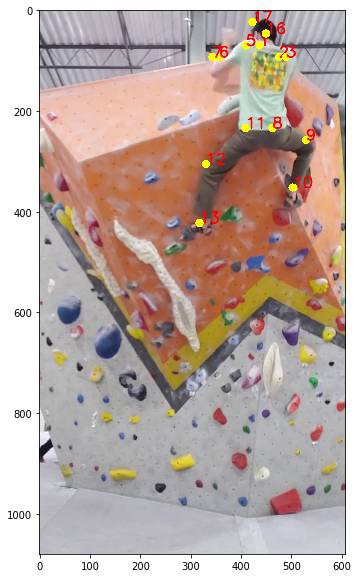

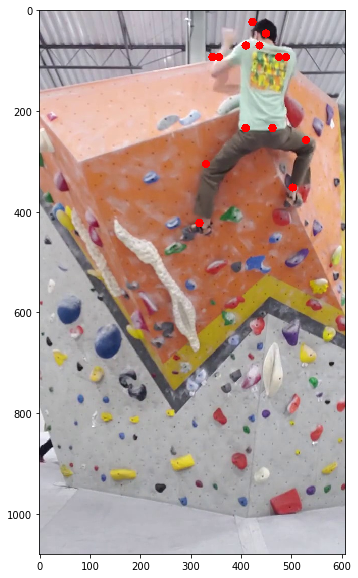

In [40]:
get_poses(volume_poses,"Volume_frames", 225)

We can see that there are issues, particularly in the baseline set, with missing values: we will solve this issue by using the fillna function first forwards (last known value) and then backwards. Also, the climbing path in the baseline video is angled: we will apply a simple overall angle estimation to transform the joint positions so that they align vertically.

In [73]:
baseline_poses = baseline_poses.fillna(method = 'pad')
baseline_poses = baseline_poses.fillna(method = 'bfill')
volume_poses = volume_poses.fillna(method = 'pad')
volume_poses = volume_poses.fillna(method = 'bfill')

In [74]:
baseline_poses.head(15)

,frame_id,time_seconds,joint0,joint1,joint2,joint3,joint4,joint5,joint6,joint7,joint8,joint9,joint10,joint11,joint12,joint13,joint14,joint15,joint16,joint17
0,0,0.00,"(876, 563)","(626, 657)","(626, 633)","(834, 516)","(834, 610)","(626, 657)","(709, 727)","(709, 751)","(709, 751)","(542, 774)","(626, 704)","(709, 751)","(626, 821)","(584, 868)","(751, 540)","(918, 540)","(709, 540)","(918, 563)"
1,5,0.17,"(876, 563)","(626, 633)","(626, 633)","(834, 516)","(834, 610)","(626, 633)","(667, 704)","(709, 751)","(667, 727)","(542, 774)","(626, 704)","(667, 727)","(542, 774)","(584, 868)","(751, 540)","(918, 540)","(709, 540)","(918, 563)"
2,10,0.33,"(876, 563)","(626, 633)","(626, 633)","(834, 516)","(834, 610)","(626, 633)","(667, 704)","(709, 751)","(626, 704)","(542, 774)","(626, 704)","(667, 727)","(542, 704)","(500, 798)","(751, 540)","(918, 540)","(709, 540)","(918, 563)"
3,15,0.50,"(876, 563)","(626, 633)","(626, 633)","(834, 516)","(834, 610)","(626, 633)","(667, 704)","(834, 610)","(626, 704)","(542, 774)","(626, 704)","(667, 727)","(542, 704)","(500, 798)","(751, 540)","(918, 540)","(709, 540)","(918, 563)"
4,20,0.67,"(876, 563)","(626, 633)","(626, 633)","(834, 516)","(834, 610)","(626, 633)","(667, 704)","(834, 610)","(626, 704)","(542, 774)","(626, 704)","(667, 727)","(542, 704)","(500, 798)","(751, 540)","(918, 540)","(709, 540)","(918, 563)"
5,25,0.83,"(876, 563)","(626, 633)","(584, 610)","(834, 516)","(834, 610)","(584, 610)","(667, 704)","(834, 610)","(626, 704)","(542, 774)","(626, 704)","(667, 727)","(542, 704)","(500, 798)","(751, 540)","(918, 540)","(709, 540)","(918, 563)"
6,30,1.00,"(876, 563)","(834, 610)","(834, 586)","(834, 516)","(834, 446)","(876, 610)","(834, 516)","(834, 446)","(709, 704)","(542, 774)","(626, 704)","(751, 704)","(542, 704)","(500, 798)","(751, 540)","(918, 540)","(709, 540)","(918, 563)"
7,35,1.17,"(751, 563)","(667, 610)","(626, 610)","(542, 680)","(834, 446)","(751, 633)","(834, 516)","(834, 516)","(709, 704)","(542, 774)","(626, 704)","(751, 704)","(542, 704)","(500, 798)","(751, 540)","(751, 540)","(709, 540)","(918, 563)"
8,40,1.33,"(876, 493)","(876, 540)","(834, 540)","(542, 680)","(834, 446)","(918, 563)","(834, 516)","(793, 469)","(709, 704)","(542, 774)","(626, 704)","(751, 704)","(542, 704)","(500, 798)","(876, 469)","(918, 493)","(709, 540)","(918, 493)"
9,45,1.50,"(876, 469)","(834, 586)","(709, 586)","(542, 680)","(834, 446)","(960, 586)","(834, 516)","(793, 469)","(709, 704)","(542, 774)","(626, 704)","(751, 704)","(542, 704)","(500, 798)","(876, 446)","(918, 469)","(793, 469)","(960, 493)"


In [75]:
volume_poses.head(15)

,frame_id,time_seconds,joint0,joint1,joint2,joint3,joint4,joint5,joint6,joint7,joint8,joint9,joint10,joint11,joint12,joint13,joint14,joint15,joint16,joint17
0,0,0.00,"(343, 281)","(383, 328)","(409, 328)","(462, 375)","(462, 375)","(343, 328)","(290, 281)","(251, 258)","(422, 469)","(422, 586)","(475, 680)","(383, 493)","(409, 586)","(489, 657)","(383, 305)","(356, 281)","(383, 305)","(356, 281)"
1,5,0.17,"(343, 281)","(383, 328)","(409, 328)","(462, 375)","(462, 352)","(343, 328)","(277, 281)","(251, 234)","(422, 469)","(449, 563)","(475, 680)","(396, 493)","(449, 563)","(528, 563)","(383, 305)","(356, 281)","(396, 305)","(356, 281)"
2,10,0.33,"(343, 281)","(383, 328)","(409, 328)","(462, 375)","(462, 375)","(343, 305)","(277, 281)","(237, 258)","(409, 446)","(436, 563)","(475, 680)","(383, 469)","(436, 563)","(528, 540)","(383, 305)","(356, 281)","(383, 281)","(356, 281)"
3,15,0.50,"(343, 281)","(370, 328)","(409, 328)","(449, 375)","(462, 352)","(343, 305)","(264, 281)","(237, 258)","(396, 446)","(422, 540)","(449, 610)","(370, 469)","(370, 586)","(422, 610)","(383, 305)","(343, 281)","(383, 281)","(343, 281)"
4,20,0.67,"(343, 281)","(356, 328)","(396, 328)","(449, 375)","(462, 352)","(330, 305)","(277, 281)","(237, 281)","(383, 446)","(422, 516)","(409, 586)","(330, 446)","(290, 563)","(370, 610)","(383, 305)","(343, 281)","(383, 281)","(343, 281)"
5,25,0.83,"(343, 281)","(356, 328)","(396, 328)","(436, 375)","(436, 352)","(330, 305)","(264, 281)","(237, 258)","(370, 446)","(409, 516)","(409, 586)","(330, 446)","(277, 540)","(317, 657)","(383, 305)","(343, 281)","(383, 281)","(343, 281)"
6,30,1.00,"(343, 281)","(356, 328)","(396, 328)","(436, 375)","(462, 352)","(317, 305)","(264, 281)","(237, 258)","(370, 469)","(409, 516)","(409, 586)","(330, 469)","(290, 563)","(290, 657)","(383, 305)","(343, 281)","(383, 305)","(356, 305)"
7,35,1.17,"(343, 281)","(356, 352)","(383, 352)","(436, 375)","(462, 352)","(317, 328)","(251, 281)","(237, 258)","(370, 469)","(409, 516)","(409, 586)","(317, 469)","(290, 540)","(290, 657)","(383, 305)","(343, 281)","(383, 305)","(343, 305)"
8,40,1.33,"(343, 281)","(343, 352)","(383, 352)","(422, 375)","(449, 352)","(304, 328)","(251, 281)","(237, 258)","(356, 469)","(409, 516)","(422, 610)","(317, 469)","(290, 540)","(304, 633)","(383, 305)","(343, 281)","(370, 328)","(343, 305)"
9,45,1.50,"(343, 281)","(343, 352)","(383, 352)","(436, 375)","(475, 352)","(304, 328)","(251, 281)","(237, 258)","(356, 469)","(396, 516)","(409, 610)","(317, 493)","(277, 540)","(290, 633)","(383, 305)","(343, 281)","(370, 328)","(330, 328)"


In [76]:
joint14_start = baseline_poses["joint14"][0]
joint14_end = baseline_poses["joint14"][num_baseline_frames - 1]
print(joint14_start, joint14_end)
x_0, y_0 = joint14_start
x_n, y_n = joint14_end
rise = y_0 - y_n # Inverted since height index decreases up the picture
run = x_n - x_0
print(rise, run)
angle = math.atan(rise/run) # Radians, use for mathematical operations
degrees = math.degrees(angle) # Degrees, use for display purposes
print(degrees)

(751, 540) (1293, 70)
470 542
40.93047753968977


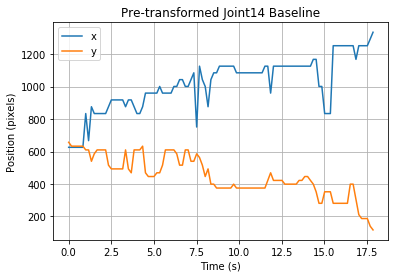

In [77]:
fig, ax = plt.subplots()
ax.plot(baseline_poses["time_seconds"].tolist(), baseline_poses["joint1"].tolist())

ax.set(xlabel='Time (s)', ylabel='Position (pixels)', 
       title='Pre-transformed Joint14 Baseline')
ax.legend(['x','y'])
ax.grid()

plt.show()

We can see that the climber in the first video is traveling along a path situated about 40 degrees relative to the camera's vertical, and we will now transform the first video's data accordingly.

In [171]:
def transform_angle(joint):
    # Takes in a list of joint positions, returns a angle-displaced list
    newJoint = []
    a = angle-(math.pi/2) # Amount to rotate by in radians
    base_x, base_y = joint[0]
    newJoint.append((base_x, base_y))
    for i in range(1,len(joint)):
        x_i, y_i = joint[i]
        dx = x_i - base_x
        dy = y_i - base_y
        new_x = math.cos(a)*dx - math.sin(a)*dy + base_x
        new_y = math.sin(a)*dx + math.cos(a)*dy + base_y
        newJoint.append((new_x, new_y))
    return newJoint

In [176]:
for n in range(18):
    baseline_poses["joint%d" % n] = transform_angle(baseline_poses["joint%d" % n].tolist())

In [177]:
baseline_poses.head(15)

,frame_id,time_seconds,joint0,joint1,joint2,joint3,joint4,joint5,joint6,joint7,joint8,joint9,joint10,joint11,joint12,joint13,joint14,joint15,joint16,joint17
0,0,0.00,"(876, 563)","(626, 657)","(626, 633)","(834, 516)","(834, 610)","(626, 657)","(709, 727)","(709, 751)","(709, 751)","(542, 774)","(626, 704)","(709, 751)","(626, 821)","(584, 868)","(751, 540)","(918, 540)","(709, 540)","(918, 563)"
1,5,0.17,"(876.0, 563.0)","(607.8678779904512, 641.2765731651514)","(626.0, 633.0)","(834.0, 516.0)","(834.0, 610.0)","(607.8678779904512, 641.2765731651514)","(664.1073861131974, 743.6629294666471)","(709.0, 751.0)","(663.3518810294662, 767.0077866818618)","(542.0, 774.0)","(626.0, 704.0)","(663.3518810294662, 767.0077866818618)","(535.4592671426636, 853.670716148509)","(584.0, 868.0)","(751.0, 540.0)","(918.0, 540.0)","(709.0, 540.0)","(918.0, 563.0)"
2,10,0.33,"(876.0, 563.0)","(607.8678779904512, 641.2765731651514)","(626.0, 633.0)","(834.0, 516.0)","(834.0, 610.0)","(607.8678779904512, 641.2765731651514)","(664.1073861131974, 743.6629294666471)","(709.0, 751.0)","(619.114409927449, 782.9152110647777)","(542.0, 774.0)","(626.0, 704.0)","(663.3518810294662, 767.0077866818618)","(482.57391128147964, 807.810721213534)","(476.082650216846, 885.6024320984457)","(751.0, 540.0)","(918.0, 540.0)","(709.0, 540.0)","(918.0, 563.0)"
3,15,0.50,"(876.0, 563.0)","(607.8678779904512, 641.2765731651514)","(626.0, 633.0)","(834.0, 516.0)","(834.0, 610.0)","(607.8678779904512, 641.2765731651514)","(664.1073861131974, 743.6629294666471)","(684.3666312920706, 564.1867318788646)","(619.114409927449, 782.9152110647777)","(542.0, 774.0)","(626.0, 704.0)","(663.3518810294662, 767.0077866818618)","(482.57391128147964, 807.810721213534)","(476.082650216846, 885.6024320984457)","(751.0, 540.0)","(918.0, 540.0)","(709.0, 540.0)","(918.0, 563.0)"
4,20,0.67,"(876.0, 563.0)","(607.8678779904512, 641.2765731651514)","(626.0, 633.0)","(834.0, 516.0)","(834.0, 610.0)","(607.8678779904512, 641.2765731651514)","(664.1073861131974, 743.6629294666471)","(684.3666312920706, 564.1867318788646)","(619.114409927449, 782.9152110647777)","(542.0, 774.0)","(626.0, 704.0)","(663.3518810294662, 767.0077866818618)","(482.57391128147964, 807.810721213534)","(476.082650216846, 885.6024320984457)","(751.0, 540.0)","(918.0, 540.0)","(709.0, 540.0)","(918.0, 563.0)"
5,25,0.83,"(876.0, 563.0)","(607.8678779904512, 641.2765731651514)","(581.1073861131974, 649.6629294666471)","(834.0, 516.0)","(834.0, 610.0)","(562.9752641036487, 657.9395026317985)","(664.1073861131974, 743.6629294666471)","(684.3666312920706, 564.1867318788646)","(619.114409927449, 782.9152110647777)","(542.0, 774.0)","(626.0, 704.0)","(663.3518810294662, 767.0077866818618)","(482.57391128147964, 807.810721213534)","(476.082650216846, 885.6024320984457)","(751.0, 540.0)","(918.0, 540.0)","(709.0, 540.0)","(918.0, 563.0)"
6,30,1.00,"(876.0, 563.0)","(726.760960299988, 469.0632316989987)","(726.760960299988, 445.0632316989987)","(834.0, 516.0)","(710.0971662680834, 502.55658329520134)","(754.276957260973, 437.3320181822883)","(631.4812754308866, 494.3267369438896)","(560.4637975601538, 456.74331517406597)","(673.4912610646336, 720.2082891150882)","(542.0, 774.0)","(626.0, 704.0)","(701.0072580256186, 688.4770755983778)","(482.57391128147964, 807.810721213534)","(476.082650216846, 885.6024320984457)","(751.0, 540.0)","(918.0, 540.0)","(709.0, 540.0)","(918.0, 563.0)"
7,35,1.17,"(794.1071519018303, 657.4381354663999)","(617.3521152408333, 595.2325806821091)","(608.6233830741824, 617.9317159499368)","(766.6011405745923, 844.0509011543088)","(710.0971662680834, 502.55658329520134)","(689.7607260886209, 546.8384376987515)","(631.4812754308866, 494.3267369438896)","(613.3491534213379, 502.60331010904105)","(673.4912610646336, 720.2082891150882)","(542.0, 774.0)","(626.0, 704.0)","(701.0072580256186, 688.4770755983778)","(482.57391128147964, 807.810721213534)","(476.082650216846, 885.6024320984457)","(751.0, 540.0)","(808.5911

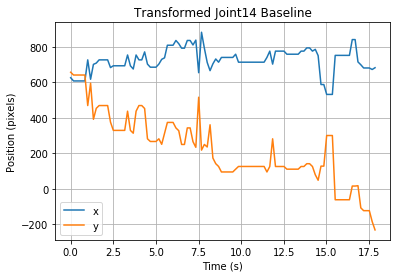

In [178]:
fig, ax = plt.subplots()
ax.plot(baseline_poses["time_seconds"].tolist(), baseline_poses["joint1"].tolist())

ax.set(xlabel='Time (s)', ylabel='Position (pixels)', 
       title='Transformed Joint14 Baseline')
ax.legend(['x','y'])
ax.grid()

plt.show()

## Stress analysis

In order to model the stresses on the climber, I created a system of equations (simplified by assuming one foot and one leg are in contact at the moments of interest) to determine peak loads based on calculated joint angles. The model I am using, along with mass and length assumptions, is as follows:

<img src="Model.jpg">

### Adding Joint Angles

From the positions gathered and the system model above, the marked angles will be calculated based on the joint data given, using force and moment balance about the center of mass. The full mapping of each described angle to the OpenPose joints is as follows:

Theta 1: Joint 2 - Joint 3

Theta 2: Joint 5 - Joint 6

Theta 3: Joint 3 - Joint 4

Theta 4: Joint 6 - Joint 7

Theta 5: Joint 8 - Joint 9

Theta 6: Joint 11 - Joint 12

Theta 7: Joint 9 - Joint 10

Theta 8: Joint 12 - Joint 13

In summary, we will use Joints 2 through 13 in calculating angles.

In [191]:
def add_angles(dataframe):
    t1,t2,t3,t4,t5,t6,t7,t8 = [],[],[],[],[],[],[],[]
    j2 = dataframe["joint2"].tolist()
    j3 = dataframe["joint3"].tolist()
    j4 = dataframe["joint4"].tolist()
    j5 = dataframe["joint5"].tolist()
    j6 = dataframe["joint6"].tolist()
    j7 = dataframe["joint7"].tolist()
    j8 = dataframe["joint8"].tolist()
    j9 = dataframe["joint9"].tolist()
    j10 = dataframe["joint10"].tolist()
    j11 = dataframe["joint11"].tolist()
    j12 = dataframe["joint12"].tolist()
    j13 = dataframe["joint13"].tolist()
    for i in range(len(j2)):
        j2_x, j2_y = j2[i]
        j3_x, j3_y = j3[i]
        j4_x, j4_y = j4[i]
        j5_x, j5_y = j5[i]
        j6_x, j6_y = j6[i]
        j7_x, j7_y = j7[i]
        j8_x, j8_y = j8[i]
        j9_x, j9_y = j9[i]
        j10_x, j10_y = j10[i]
        j11_x, j11_y = j11[i]
        j12_x, j12_y = j12[i]
        j13_x, j13_y = j13[i]
        t1_i = math.atan2((j2_y-j3_y),(j2_x-j3_x)) % math.pi
        t2_i = math.atan2((j5_y-j6_y),(j6_x-j5_x)) % math.pi
        t3_i = t1_i - math.atan2((j3_y-j4_y),(j3_x-j4_x)) % math.pi
        t4_i = t2_i - math.atan2((j6_y-j7_y),(j7_x-j6_x)) % math.pi
        t5_i = math.atan2((j8_x-j9_x),(j9_y-j8_y)) % math.pi
        t6_i = math.atan2((j12_x-j11_x),(j12_y-j11_y)) % math.pi
        t7_i = t5_i - math.atan2((j9_x-j10_x),(j10_y-j9_y)) % math.pi
        t8_i = t6_i - math.atan2((j13_x-j12_x),(j13_y-j12_y)) % math.pi
        t1.append(t1_i)
        t2.append(t2_i)
        t3.append(t3_i)
        t4.append(t4_i)
        t5.append(t5_i)
        t6.append(t6_i)
        t7.append(t7_i)
        t8.append(t8_i)
    dataframe["theta_1"] = t1
    dataframe["theta_2"] = t2
    dataframe["theta_3"] = t3
    dataframe["theta_4"] = t4
    dataframe["theta_5"] = t5
    dataframe["theta_6"] = t6
    dataframe["theta_7"] = t7
    dataframe["theta_8"] = t8
    return dataframe

I am assuming the climber weighs a total of 60 kg, with center of mass always at the center of their torso as shown. I further assume that the X-direction of the rock interaction forces with hands and feet are negligible. 

We will now use this setup to estimate hand and foot forces in Newtons at each instant, based on the angles and mass/length assumptions.

In [192]:
def calc_forces(dataframe):
    m1, m2, m3, m4 = 1, 2, 6, 3
    mb = 36
    m_total = 60
    L, l1, l2, l3, l4 = .36, .33, .3, .5, .35
    F_hand, F_foot = [], []
    
    t1 = dataframe["theta_1"].tolist()
    t2 = dataframe["theta_2"].tolist()
    t3 = dataframe["theta_3"].tolist()
    t4 = dataframe["theta_4"].tolist()
    t5 = dataframe["theta_5"].tolist()
    t6 = dataframe["theta_6"].tolist()
    t7 = dataframe["theta_7"].tolist()
    t8 = dataframe["theta_8"].tolist()
    
    for i in range(len(dataframe["theta_1"])):
        c1 = l1*(m1/2 + m2)*(math.cos(t2[i])-math.cos(t1[i]))
        c2 = l2*(m2/2)*(math.cos(t2[i]-t4[i])-math.cos(t1[i]-t3[i]))
        c3 = l3*(m3/2 + m4)*(math.sin(t6[i])-math.sin(t5[i]))
        c4 = l4*(m4/2)*(math.sin(t6[i]-t8[i])-math.sin(t5[i]-t7[i]))
        C = c1 + c2 + c3 + c4
        P = 9.81/(l1*math.cos(t1[i])+l2*math.cos(t1[i]-t3[i])+l3*math.sin(t6[i])+l4*math.sin(t6[i]-t8[i])+L)
        F1 = P*(m_total*(l3*math.sin(t6[i]+l4*math.sin(t6[i]-t8[i])+L/2))-C)
        F4 = 9.81*m_total - F1
        F_hand.append(F1)
        F_foot.append(F4)
    dataframe["F_hand"] = F_hand
    dataframe["F_foot"] = F_foot
    return dataframe

In [193]:
baseline_poses = add_angles(baseline_poses)
baseline_poses = calc_forces(baseline_poses)
baseline_poses["hand_stress"] = baseline_poses["F_hand"]/.01
baseline_poses["foot_stress"] = baseline_poses["F_foot"]/.01
baseline_poses.head(15)

,frame_id,time_seconds,joint0,joint1,joint2,joint3,joint4,joint5,joint6,joint7,...,theta_3,theta_4,theta_5,theta_6,theta_7,theta_8,F_hand,F_foot,hand_stress,foot_stress
0,0,0.00,"(876, 563)","(626, 657)","(626, 633)","(834, 516)","(834, 610)","(626, 657)","(709, 727)","(709, 751)",...,1.06,0.87,1.43,2.27,0.56,-0.14,197.97,390.63,"19,796.54","39,063.46"
1,5,0.17,"(876.0, 563.0)","(607.8678779904512, 641.2765731651514)","(626.0, 633.0)","(834.0, 516.0)","(834.0, 610.0)","(607.8678779904512, 641.2765731651514)","(664.1073861131974, 743.6629294666471)","(709.0, 751.0)",...,1.06,-0.91,1.51,2.17,0.64,0.88,163.41,425.19,"16,341.27","42,518.73"
2,10,0.33,"(876.0, 563.0)","(607.8678779904512, 641.2765731651514)","(626.0, 633.0)","(834.0, 516.0)","(834.0, 610.0)","(607.8678779904512, 641.2765731651514)","(664.1073861131974, 743.6629294666471)","(709.0, 751.0)",...,1.06,-0.91,1.69,1.79,0.81,-1.27,460.23,128.37,"46,023.45","12,836.55"
3,15,0.50,"(876.0, 563.0)","(607.8678779904512, 641.2765731651514)","(626.0, 633.0)","(834.0, 516.0)","(834.0, 610.0)","(607.8678779904512, 641.2765731651514)","(664.1073861131974, 743.6629294666471)","(684.3666312920706, 564.1867318788646)",...,1.06,0.61,1.69,1.79,0.81,-1.27,454.74,133.86,"45,474.49","13,385.51"
4,20,0.67,"(876.0, 563.0)","(607.8678779904512, 641.2765731651514)","(626.0, 633.0)","(834.0, 516.0)","(834.0, 610.0)","(607.8678779904512, 641.2765731651514)","(664.1073861131974, 743.6629294666471)","(684.3666312920706, 564.1867318788646)",...,1.06,0.61,1.69,1.79,0.81,-1.27,454.74,133.86,"45,474.49","13,385.51"
5,25,0.83,"(876.0, 563.0)","(607.8678779904512, 641.2765731651514)","(581.1073861131974, 649.6629294666471)","(834.0, 516.0)","(834.0, 610.0)","(562.9752641036487, 657.9395026317985)","(664.1073861131974, 743.6629294666471)","(684.3666312920706, 564.1867318788646)",...,1.08,0.98,1.69,1.79,0.81,-1.27,461.68,126.92,"46,167.82","12,692.18"
6,30,1.00,"(876.0, 563.0)","(726.760960299988, 469.0632316989987)","(726.760960299988, 445.0632316989987)","(834.0, 516.0)","(710.0971662680834, 502.55658329520134)","(754.276957260973, 437.3320181822883)","(631.4812754308866, 494.3267369438896)","(560.4637975601538, 456.74331517406597)",...,0.48,-2.22,1.18,2.07,0.31,-0.99,166.43,422.17,"16,643.05","42,216.95"
7,35,1.17,"(794.1071519018303, 657.4381354663999)","(617.3521152408333, 595.2325806821091)","(608.6233830741824, 617.9317159499368)","(766.6011405745923, 844.0509011543088)","(710.0971662680834, 502.55658329520134)","(689.7607260886209, 546.8384376987515)","(631.4812754308866, 494.3267369438896)","(613.3491534213379, 502.60331010904105)",...,-0.45,1.98,1.18,2.07,0.31,-0.99,222.12,366.48,"22,211.73","36,648.27"
8,40,1.33,"(823.1146441388161, 517.140005065025)","(701.391601399789, 391.4720232473133)","(692.0077264483529, 414.92666359887227)","(766.6011405745923, 844.0509011543088)","(710.0971662680834, 502.55658329520134)","(746.2842152865917, 374.80909378066616)","(631.4812754308866, 494.3267369438896)","(550.9795603097718, 502.7873076571084)",...,-0.01,0.70,1.18,2.07,0.31,-0.99,237.45,351.15,"23,744.72","35,115.28"
9,45,1.50,"(804.9825221292673, 501.41657823017636)","(708.6288382904393, 453.3398048641501)","(644.8681122018183, 539.5013671653986)","(766.6011405745923, 844.0509011543088)","(710.0971662680834, 502.55658329520134)","(791.1768291733943, 358.146164314019)","(631.4812754308866, 494.3267369438896)","(550.9795603097718, 502.7873076571084)",...,-0.22,0.60,1.18,2.07,0.31,-0.99,222.84,365.76,"22,283.99","36,576.01"


In [194]:
volume_poses = add_angles(volume_poses)
volume_poses = calc_forces(volume_poses)
volume_poses["hand_stress"] = volume_poses["F_hand"]/.01
volume_poses["foot_stress"] = volume_poses["F_foot"]/.01
volume_poses.head(15)

,frame_id,time_seconds,joint0,joint1,joint2,joint3,joint4,joint5,joint6,joint7,...,theta_3,theta_4,theta_5,theta_6,theta_7,theta_8,F_hand,F_foot,hand_stress,foot_stress
0,0,0.00,"(343, 281)","(383, 328)","(409, 328)","(462, 375)","(462, 375)","(343, 328)","(290, 281)","(251, 258)",...,0.73,-0.19,0.00,0.27,-2.63,-0.57,154.34,434.26,"15,434.17","43,425.83"
1,5,0.17,"(343, 281)","(383, 328)","(409, 328)","(462, 375)","(462, 352)","(343, 328)","(277, 281)","(251, 234)",...,-0.85,0.45,2.86,0.65,-0.06,-0.92,216.32,372.28,"21,632.45","37,227.55"
2,10,0.33,"(343, 281)","(383, 328)","(409, 328)","(462, 375)","(462, 375)","(343, 305)","(277, 281)","(237, 258)",...,0.73,0.17,2.91,0.51,0.09,-1.30,174.73,413.87,"17,472.92","41,387.08"
3,15,0.50,"(343, 281)","(370, 328)","(409, 328)","(449, 375)","(462, 352)","(343, 305)","(264, 281)","(237, 258)",...,-1.22,0.41,2.87,0.00,0.10,-1.14,214.14,374.46,"21,413.54","37,446.46"
4,20,0.67,"(343, 281)","(356, 328)","(396, 328)","(449, 375)","(462, 352)","(330, 305)","(277, 281)","(237, 281)",...,-1.36,2.72,2.63,2.81,2.45,1.77,-37.20,625.80,"-3,719.52","62,579.52"
5,25,0.83,"(343, 281)","(356, 328)","(396, 328)","(436, 375)","(436, 352)","(330, 305)","(264, 281)","(237, 258)",...,-0.71,0.36,2.63,2.63,2.63,2.30,83.17,505.43,"8,316.98","50,543.02"
6,30,1.00,"(343, 281)","(356, 328)","(396, 328)","(436, 375)","(462, 352)","(317, 305)","(264, 281)","(237, 258)",...,-1.55,0.28,2.45,2.74,2.45,2.74,155.64,432.96,"15,563.62","43,296.38"
7,35,1.17,"(343, 281)","(356, 352)","(383, 352)","(436, 375)","(462, 352)","(317, 328)","(251, 281)","(237, 258)",...,-2.01,0.41,2.45,2.78,2.45,2.78,122.36,466.24,"12,236.42","46,623.58"
8,40,1.33,"(343, 281)","(343, 352)","(383, 352)","(422, 375)","(449, 352)","(304, 328)","(251, 281)","(237, 258)",...,-1.90,0.30,2.30,2.78,-0.71,2.63,96.55,492.05,"9,654.89","49,205.11"
9,45,1.50,"(343, 281)","(343, 352)","(383, 352)","(436, 375)","(475, 352)","(304, 328)","(251, 281)","(237, 258)",...,-2.20,0.30,2.44,2.44,-0.57,2.30,189.87,398.73,"18,986.94","39,873.06"


Now that we have calculated hand and foot forces and associated stresses (assuming hand and foot surface areas of .01 square meters) at each instant, we want to retrieve and compare the maxima in each instance, using simple descriptive statistics:

In [195]:
baseline_poses.describe()

,frame_id,time_seconds,theta_1,theta_2,theta_3,theta_4,theta_5,theta_6,theta_7,theta_8,F_hand,F_foot,hand_stress,foot_stress
count,108.00,108.00,108.00,108.00,108.00,108.00,108.00,108.00,108.00,108.00,108.00,108.00,108.00,108.00
mean,267.50,8.93,1.07,1.41,-0.76,-0.07,1.85,2.13,-0.09,-0.21,172.49,416.11,"17,248.93","41,611.07"
std,156.60,5.23,0.75,0.66,1.25,0.98,0.75,0.65,0.86,1.03,130.33,130.33,"13,033.23","13,033.23"
min,0.00,0.00,0.01,0.18,-2.85,-2.52,0.05,0.05,-1.84,-2.65,-93.47,70.56,"-9,346.74","7,056.49"
25%,133.75,4.46,0.64,0.91,-1.76,-0.76,1.19,1.82,-0.58,-0.96,80.03,358.00,"8,002.94","35,799.92"
50%,267.50,8.93,0.85,1.34,-0.86,0.09,1.83,2.14,0.02,-0.41,166.47,422.13,"16,647.32","42,212.68"
75%,401.25,13.39,1.18,1.99,0.08,0.62,2.42,2.68,0.45,-0.02,230.60,508.57,"23,060.08","50,857.06"
max,535.00,17.85,3.02,3.05,2.85,1.98,3.09,3.14,2.28,2.43,518.04,682.07,"51,803.51","68,206.74"


In [196]:
volume_poses.describe()

,frame_id,time_seconds,theta_1,theta_2,theta_3,theta_4,theta_5,theta_6,theta_7,theta_8,F_hand,F_foot,hand_stress,foot_stress
count,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00
mean,122.50,4.09,1.08,1.15,-0.57,-0.48,1.80,1.90,0.55,1.01,177.74,410.86,"17,774.05","41,085.95"
std,72.89,2.43,0.91,1.06,1.12,1.22,1.07,0.82,1.63,1.26,120.31,120.31,"12,031.23","12,031.23"
min,0.00,0.00,0.00,0.00,-2.42,-2.62,0.00,0.00,-2.94,-2.08,-251.84,221.61,"-25,183.95","22,161.25"
25%,61.25,2.04,0.41,0.30,-1.63,-1.36,1.04,1.29,-0.22,-0.03,132.29,333.36,"13,228.51","33,335.52"
50%,122.50,4.09,0.87,0.77,-0.04,-0.18,2.09,2.11,0.15,0.91,174.54,414.06,"17,454.18","41,405.82"
75%,183.75,6.13,2.09,2.42,0.40,0.30,2.84,2.50,1.89,2.19,255.24,456.31,"25,524.48","45,631.49"
max,245.00,8.17,2.52,2.85,1.03,2.72,3.03,3.00,3.00,2.82,366.99,840.44,"36,698.75","84,043.95"


From this, it appears we have a peak hand load of 518.04 N on the system board, and a peak hand load of 366.99 N on the volume. The peak foot load is 682.07 N on the system board, and 840.44 N on the volume.

Assuming the hand force to be evenly distributed over an area of .01 square meters and foot force to be evenly distributed over an area of .01 square meters, these would translate to peak stresses of:

51.804 kPa on hands and 68.207 kPa on feet during system board motion

36.699 kPa on hands and 84.044 kPa on feet during volume motion

Judging from the distribution, however, I cannot come to a definitive conclusion about the effect of the volume transition motion on loads/stresses: the measures of centrality were very similar in both cases.

### Visualizations

Here, I will also visualize the angles and loads over time for further comparisons.

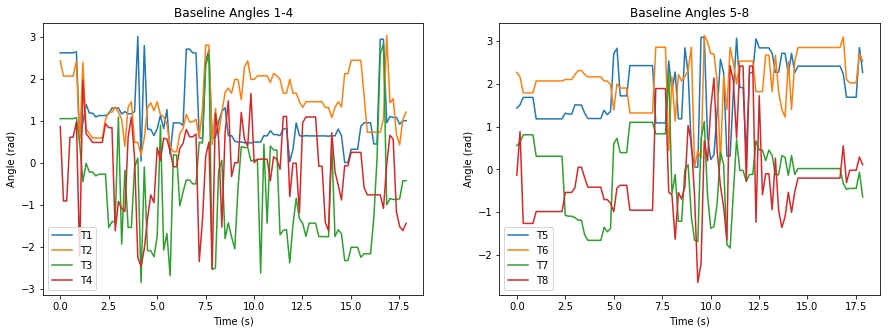

In [208]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15,5))
time = baseline_poses["time_seconds"].tolist()
t1 = baseline_poses["theta_1"].tolist()
t2 = baseline_poses["theta_2"].tolist()
t3 = baseline_poses["theta_3"].tolist()
t4 = baseline_poses["theta_4"].tolist()
t5 = baseline_poses["theta_5"].tolist()
t6 = baseline_poses["theta_6"].tolist()
t7 = baseline_poses["theta_7"].tolist()
t8 = baseline_poses["theta_8"].tolist()

ax1.set_title("Baseline Angles 1-4")
ax2.set_title("Baseline Angles 5-8")
ax1.set_xlabel("Time (s)")
ax2.set_xlabel("Time (s)")
ax1.set_ylabel("Angle (rad)")
ax2.set_ylabel("Angle (rad)")

sns.lineplot(time, t1, ax = ax1, label = 'T1')
sns.lineplot(time, t2, ax = ax1, label = 'T2')

sns.lineplot(time, t3, ax = ax1, label = 'T3')
sns.lineplot(time, t4, ax = ax1, label = 'T4')

sns.lineplot(time, t5, ax = ax2, label = 'T5')
sns.lineplot(time, t6, ax = ax2, label = 'T6')

sns.lineplot(time, t7, ax = ax2, label = 'T7')
sns.lineplot(time, t8, ax = ax2, label = 'T8')

plt.show()

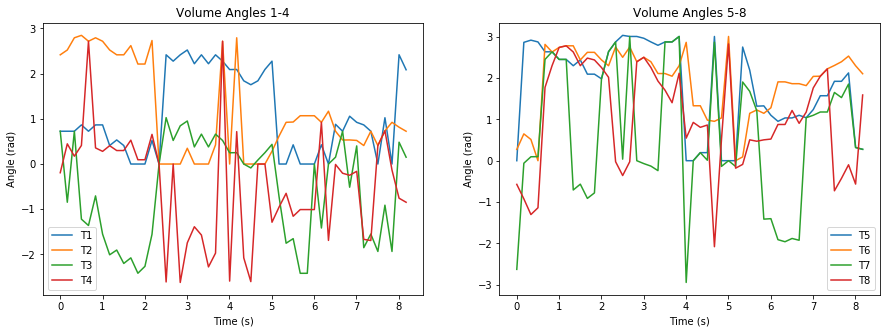

In [209]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15,5))
time = volume_poses["time_seconds"].tolist()
t1 = volume_poses["theta_1"].tolist()
t2 = volume_poses["theta_2"].tolist()
t3 = volume_poses["theta_3"].tolist()
t4 = volume_poses["theta_4"].tolist()
t5 = volume_poses["theta_5"].tolist()
t6 = volume_poses["theta_6"].tolist()
t7 = volume_poses["theta_7"].tolist()
t8 = volume_poses["theta_8"].tolist()

ax1.set_title("Volume Angles 1-4")
ax2.set_title("Volume Angles 5-8")
ax1.set_xlabel("Time (s)")
ax2.set_xlabel("Time (s)")
ax1.set_ylabel("Angle (rad)")
ax2.set_ylabel("Angle (rad)")

sns.lineplot(time, t1, ax = ax1, label = 'T1')
sns.lineplot(time, t2, ax = ax1, label = 'T2')

sns.lineplot(time, t3, ax = ax1, label = 'T3')
sns.lineplot(time, t4, ax = ax1, label = 'T4')

sns.lineplot(time, t5, ax = ax2, label = 'T5')
sns.lineplot(time, t6, ax = ax2, label = 'T6')

sns.lineplot(time, t7, ax = ax2, label = 'T7')
sns.lineplot(time, t8, ax = ax2, label = 'T8')

plt.show()

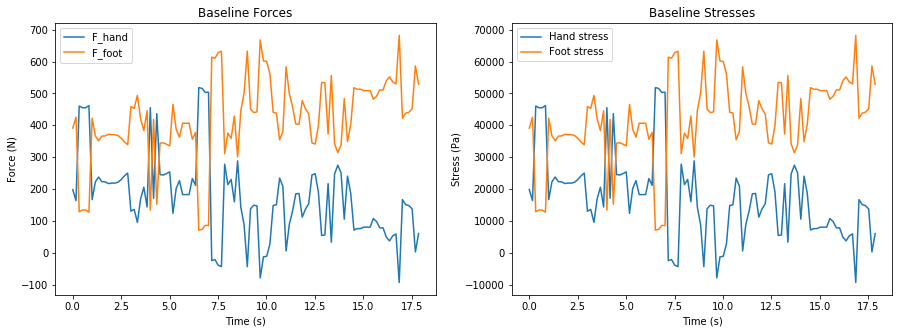

In [215]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15,5))
time = baseline_poses["time_seconds"].tolist()
F_hand = baseline_poses["F_hand"].tolist()
F_foot = baseline_poses["F_foot"].tolist()
hand_stress = baseline_poses["hand_stress"].tolist()
foot_stress = baseline_poses["foot_stress"].tolist()

ax1.set_title("Baseline Forces")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Force (N)")
ax2.set_title("Baseline Stresses")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Stress (Pa)")

sns.lineplot(time, F_hand, ax = ax1, label = 'F_hand')
sns.lineplot(time, F_foot, ax = ax1, label = 'F_foot')

sns.lineplot(time, hand_stress, ax = ax2, label = 'Hand stress')
sns.lineplot(time, foot_stress, ax = ax2, label = 'Foot stress')

plt.show()

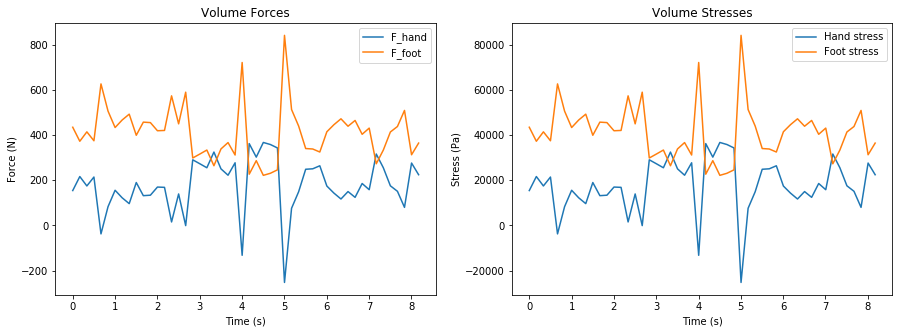

In [216]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15,5))
time = volume_poses["time_seconds"].tolist()
F_hand = volume_poses["F_hand"].tolist()
F_foot = volume_poses["F_foot"].tolist()
hand_stress = volume_poses["hand_stress"].tolist()
foot_stress = volume_poses["foot_stress"].tolist()

ax1.set_title("Volume Forces")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Force (N)")
ax2.set_title("Volume Stresses")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Stress (Pa)")

sns.lineplot(time, F_hand, ax = ax1, label = 'F_hand')
sns.lineplot(time, F_foot, ax = ax1, label = 'F_foot')

sns.lineplot(time, hand_stress, ax = ax2, label = 'Hand stress')
sns.lineplot(time, foot_stress, ax = ax2, label = 'Foot stress')

plt.show()

While the effects of the volume motion on peak load or peak stress are not statistically significant from my analysis, there is a clear distinction in the patterns over time of the joint angles and applied forces between the system board and volume videos.

In the system board motion, the joint angles and forces/stresses across different limbs increasingly diverge in magnitude, while in the volume case they remain relatively closer together in smaller positive magnitudes, indicating a more tightly posture. In particular, T7 and T8 both remained near zero in the system board case: this would indicate a stiffer lower leg without bending one's knees in this straight motion.

The results were very volatile overall, with the volume positions being less eratic, possibly due to instability in the pose detection or the rotation transformation applied. though it is also possible the volume transition motion simply requires a more stable positioning.

In general, one can see that during both types of motion that opposing joints (i.e. each knee, for example) tend to alter their angles counter to each other. This can be attributed to the cyclical nature of rock climbing, in alternating limbs to latch onto the next ledge. However, these opposing joints also have a tendency to even out around the same equilibria, indicating a symmetrical motion across limbs. This held true for the volume motion, while existing literature supports the simpler straight line case.

In [217]:
# Final data file creation
baseline_poses.to_csv('baseline_data.csv', index = False)
volume_poses.to_csv('volume_data.csv', index = False)